# Demo for paper "First Order Motion Model for Image Animation"

**Add folder https://drive.google.com/drive/folders/1kZ1gCnpfU0BnpdU47pLM_TQ6RypDDqgw?usp=sharing  to your google drive.
Alternativelly you can use this mirror link https://drive.google.com/drive/folders/16inDpBRPT1UC0YMGMX3dKvRnOUsf5Dhn?usp=sharing**

In [36]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
import tensorflow.compat.v1 as tf
from PIL import Image
import os

In [3]:
train_dir = 'data/softmotion30_44k/train/'
trainfiles = [train_dir + f for f in os.listdir(train_dir)]
trainfiles.sort()
trainfiles = trainfiles[5:20]
trainfiles

['data/softmotion30_44k/train/traj_11198_to_11453.tfrecords',
 'data/softmotion30_44k/train/traj_11454_to_11709.tfrecords',
 'data/softmotion30_44k/train/traj_11710_to_11965.tfrecords',
 'data/softmotion30_44k/train/traj_11966_to_12221.tfrecords',
 'data/softmotion30_44k/train/traj_12222_to_12477.tfrecords',
 'data/softmotion30_44k/train/traj_12478_to_12733.tfrecords',
 'data/softmotion30_44k/train/traj_12734_to_12989.tfrecords',
 'data/softmotion30_44k/train/traj_1280_to_1535.tfrecords',
 'data/softmotion30_44k/train/traj_12990_to_13245.tfrecords',
 'data/softmotion30_44k/train/traj_13341_to_13596.tfrecords',
 'data/softmotion30_44k/train/traj_13597_to_13852.tfrecords',
 'data/softmotion30_44k/train/traj_13853_to_14108.tfrecords',
 'data/softmotion30_44k/train/traj_14109_to_14364.tfrecords',
 'data/softmotion30_44k/train/traj_14365_to_14620.tfrecords',
 'data/softmotion30_44k/train/traj_14621_to_14876.tfrecords']

In [4]:
test_dir = 'data/softmotion30_44k/test/'
testfiles = [test_dir + f for f in os.listdir(test_dir)]
testfiles.sort()
testfiles

['data/softmotion30_44k/test/traj_0_to_255.tfrecords']

In [5]:
import torch
from demo import load_checkpoints, detect
generator, kp_detector = load_checkpoints(config_path='config/bair-256.yaml', 
                            checkpoint_path='demo/bair-cpk.pth.tar')

In [ ]:
values, jacobians = [], []

for f in trainfiles:
    k=0
    for serialized_example in tqdm(tf.python_io.tf_record_iterator(f)):
        example = tf.train.Example()
        example.ParseFromString(serialized_example)
        image_seq = []
        for i in range(30):
            image_name = str(i) + '/image_aux1/encoded'
            byte_str = example.features.feature[image_name].bytes_list.value[0]
            img = Image.frombytes('RGB', (64, 64), byte_str).resize((256, 256))
            arr = np.array(img.getdata()).reshape(img.size[1], img.size[0], 3)
            image_seq.append(arr.reshape(1, 256, 256, 3) / 255.)
        image_seq = np.concatenate(image_seq, axis=0)
        value, jacobian = detect(image_seq, kp_detector)
        values.append(value.cpu())
        jacobians.append(jacobian.cpu())
        k+=1

In [16]:
import pickle

values = pickle.load(open("values.p", "rb")) + values
jacobians = pickle.load(open("jacobians.p", "rb")) + jacobians

In [17]:
pickle.dump(values, open( "values_train.p", "wb" ) )
pickle.dump(jacobians, open( "jacobians_train.p", "wb" ) )

###  Convert Test Videos to MP4

In [21]:
for f in testfiles:
    k=0
    for serialized_example in tqdm(tf.python_io.tf_record_iterator(f)):
        sk=str(k).zfill(3)
        example = tf.train.Example()
        example.ParseFromString(serialized_example)
        image_seq = []
        for i in range(30):
            image_name = str(i) + '/image_aux1/encoded'
            byte_str = example.features.feature[image_name].bytes_list.value[0]
            img = Image.frombytes('RGB', (64, 64), byte_str).resize((256, 256))
            arr = np.array(img.getdata()).reshape(img.size[1], img.size[0], 3)
            arr = arr.astype(np.uint8)
            if i == 0:
                imageio.imsave(f'test_videos/first_images/{sk}.png', arr)
            image_seq.append(arr.reshape(1, 256, 256, 3))
        image_seq = np.concatenate(image_seq, axis=0)
        imageio.mimsave(f'test_videos/videos/{sk}.mp4', image_seq)
        k+=1

256it [10:08,  2.38s/it]


### Test Generated Motion

In [8]:
from demo import kp_animation
from skimage import img_as_ubyte

def read_video(path):
    reader = imageio.get_reader(path)

    fps = reader.get_meta_data()['fps']
    driving_video = []
    try:
        for im in reader:
            driving_video.append(im)
    except RuntimeError:
        pass
    reader.close()
    
    return fps, driving_video[:16]


def display(*arg):
    fig = plt.figure(figsize=(4 * len(arg), 6))

    ims = []
    for i in range(len(arg[-1])):
        cols = []
        for element in arg:
            if isinstance(element, list): # video
                cols.append(element[i])
            else: # image
                cols.append(element)
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=150, repeat_delay=1000)
    plt.close()
    return ani


def linear_interpolation(source_img, target_img):
    res = []
    for i in range(16):
        alpha = i / 15.
        img = source_img * (1-alpha) + target_img * alpha
        res.append(img.astype(np.uint8))
    return res

In [114]:
device = torch.device('cuda')
#rec_value = np.load('pickle/rec_value.npy')
#rec_jacobian = np.load('pickle/rec_jacobian.npy')
rec_value = np.load('pickle/GAN_values_1.npy')
rec_jacobian = np.load('pickle/GAN_jacobians_1.npy')

kpss = []
for k in range(256):
    kps = []
    for frame in range(16):
        kp = {}
        kp['value'] = torch.from_numpy(rec_value[k][frame:frame+1]).to(device)
        kp['jacobian'] = torch.from_numpy(rec_jacobian[k][frame:frame+1]).to(device)
        kps.append(kp)
    kpss.append(kps)

In [115]:
to_save = []
for k in tqdm(range(256)):
    sk=str(k).zfill(3)
    
    source_image = imageio.imread(f'test_videos/first_images/{sk}.png')
    source_image = resize(source_image, (256, 256))[..., :3]
    predictions = kp_animation(source_image, kpss[k], generator)
    
    predictions_ = [resize(frame, (64, 64))[..., :3] for frame in predictions]
    to_save.append(predictions_)
    imageio.mimsave(f'test_videos/GANgenerated1/{sk}.mp4', [img_as_ubyte(frame) for frame in predictions], fps=10.0)

100%|██████████| 256/256 [04:28<00:00,  1.05s/it]


In [97]:
pickle.dump(to_save, open( "GAN2.p", "wb" ) )

In [9]:
sk = '011'
_, predict_video = read_video(f'test_videos/generated/{sk}.mp4')
_, actual_video  = read_video(f'test_videos/videos/{sk}.mp4')
_, convol_video  = read_video(f'test_videos/convolution/{sk}.mp4')
source_image = actual_video[0]
target_image = actual_video[-1]
linear_video = linear_interpolation(source_image, target_image)
HTML(display(actual_video, linear_video, convol_video, predict_video).to_html5_video()) 

In [131]:
def display_video_seq(*videos):
    for video in videos:
        fig = plt.figure(figsize=(10 * 2, 2))
        for frame_id in range(1, 17):
            ax = fig.add_axes([frame_id * 1 / 16., 0, (frame_id + 1) * 1 / 16., 1],
                              xmargin=0, ymargin=0)
            ax.imshow(video[frame_id - 1])
            ax.axis('off')
    plt.tight_layout()

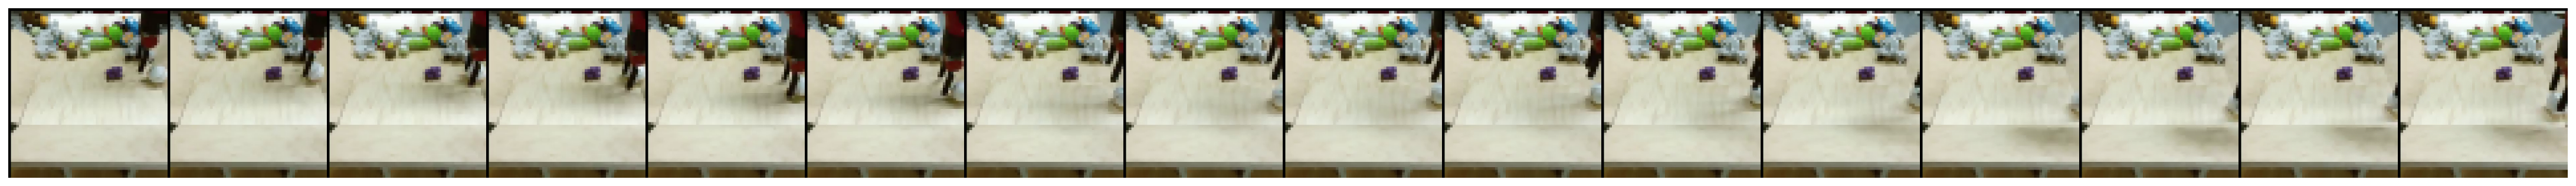

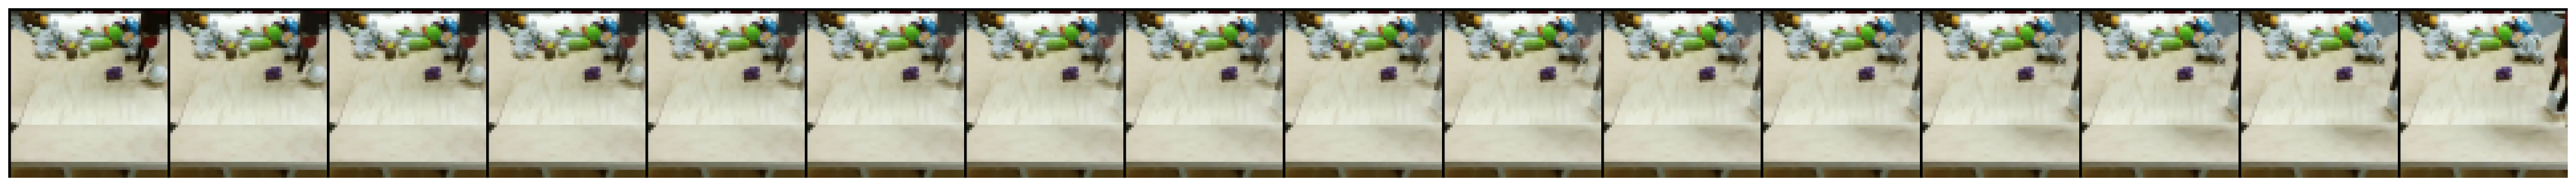

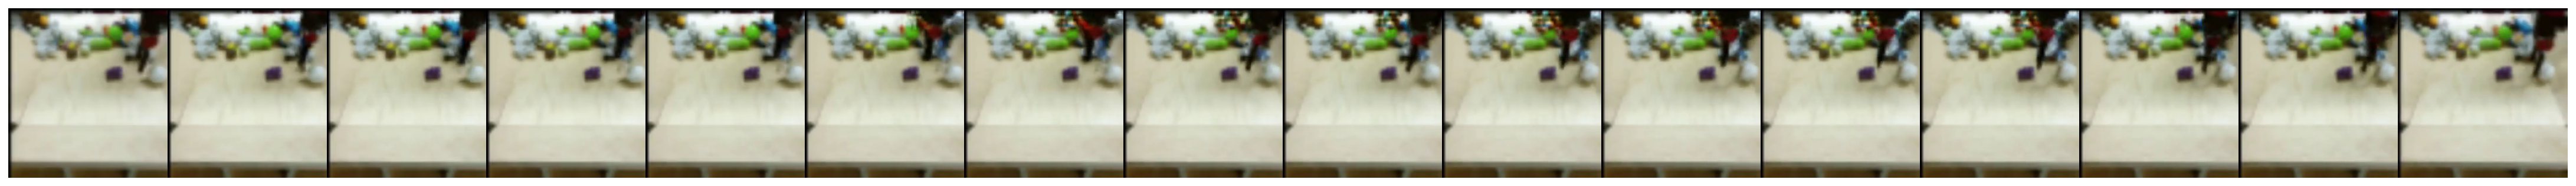

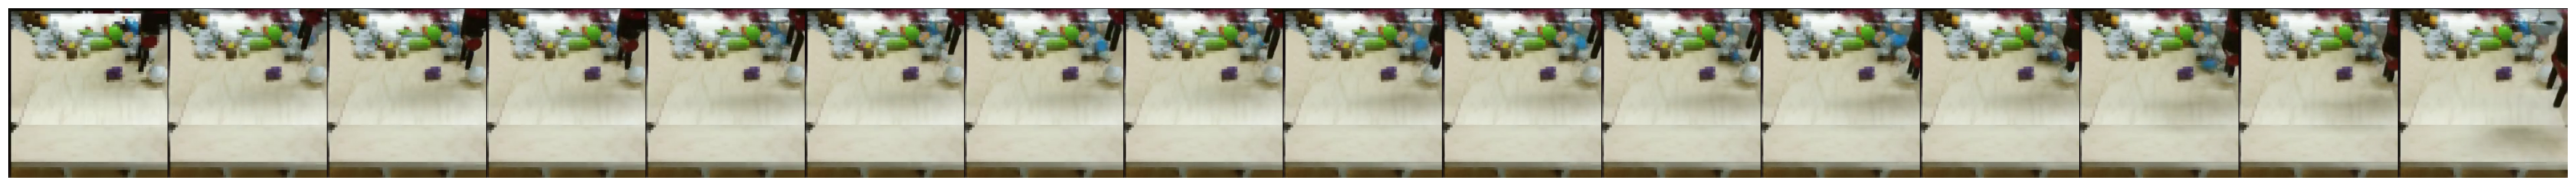

In [135]:
display_video_seq(actual_video, linear_video, convol_video, predict_video, GAN_video_1, GAN_video_2, GAN_video_3)

In [133]:
sk = '011'
_, GAN_video_1 = read_video(f'test_videos/GANgenerated1/{sk}.mp4')
_, GAN_video_2 = read_video(f'test_videos/GANgenerated2/{sk}.mp4')
_, GAN_video_3 = read_video(f'test_videos/GANgenerated3/{sk}.mp4')
_, actual_video  = read_video(f'test_videos/videos/{sk}.mp4')
HTML(display(actual_video, GAN_video_1, GAN_video_2, GAN_video_3).to_html5_video()) 

In [ ]:
"""
input_framess = []
for k in tqdm(range(16)):
    input_frames = np.zeros((16, 2, 64, 64, 3))
    for i in range(16):
        _, video = read_video(f'test_videos/videos/{str(i + k * 16).zfill(3)}.mp4')
        input_frames[i, 0] = resize(video[0], (64, 64))[..., :3] * 255
        input_frames[i, 1] = resize(video[1], (64, 64))[..., :3] * 255
    input_framess.append(np.around(input_frames).astype(np.uint8))

pickle.dump(input_framess, open( "save.p", "wb" ) )
"""